In [1]:
import sys, os
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


In [11]:
chm = project_root+str("/src")
sys.path.append(chm)

In [13]:
%matplotlib inline

import torch
import matplotlib.pyplot as plt

from torch_geometric.datasets import QM9
from egnn_qm9.data import PROPERTY_TO_IDX  # from your project


In [ ]:
dataset = QM9(root="../data/QM9")   
len(dataset)


130831

In [15]:
def pairwise_distances(pos: torch.Tensor) -> torch.Tensor:
    """
    pos: (N, 3)
    returns distances for all unique pairs i < j as a 1D tensor.
    """
    N = pos.size(0)
    diff = pos.unsqueeze(0) - pos.unsqueeze(1)     # (N, N, 3)
    dist_matrix = diff.norm(dim=-1)               # (N, N)
    i, j = torch.triu_indices(N, N, offset=1)
    return dist_matrix[i, j]                      # (N_pairs,)


In [17]:
from tqdm import tqdm
def select_by_num_atoms(dataset, n_atoms: int):
    return [data for data in tqdm(dataset,desc=f"selecting by number of atoms of : {n_atoms}") if data.num_nodes == n_atoms]

n_atoms = 7
subset = select_by_num_atoms(dataset, n_atoms)
len(subset)


selecting by number of atoms of : 7: 100%|██████████| 130831/130831 [00:09<00:00, 13911.25it/s]


20

In [18]:
def select_by_property_range(dataset, prop_name: str, low: float, high: float):
    idx = PROPERTY_TO_IDX[prop_name]
    selected = []
    for d in tqdm(dataset,desc=f"selecting by property {prop_name} in range [{low}, {high}]"):
        # d.y shape is [1, 19], so index like this:
        y_val = d.y[0, idx].item()
        if low <= y_val <= high:
            selected.append(d)
    return selected

subset_mu = select_by_property_range(dataset, "mu", 0.0, 1.0)
len(subset_mu)


selecting by property mu in range [0.0, 1.0]: 100%|██████████| 130831/130831 [00:06<00:00, 21271.28it/s]


12244

In [19]:
subset = select_by_property_range(dataset, "mu", 0.0, 1.0)   # or subset_mu, etc.
print(f"Selected {len(subset)} molecules")

all_dists = []

for data in subset:
    dists = pairwise_distances(data.pos)
    all_dists.append(dists)

all_dists = torch.cat(all_dists, dim=0)
all_dists.shape


selecting by property mu in range [0.0, 1.0]: 100%|██████████| 130831/130831 [00:05<00:00, 22670.51it/s]


Selected 12244 molecules


torch.Size([2367978])

In [20]:
print("min:", all_dists.min().item())
print("max:", all_dists.max().item())
print("mean:", all_dists.mean().item())
print("std:", all_dists.std().item())


min: 0.9593811631202698
max: 12.040427207946777
mean: 3.374652147293091
std: 1.4144662618637085


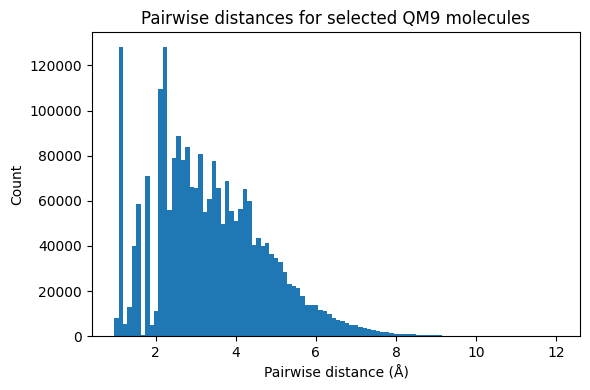

In [21]:
plt.figure(figsize=(6,4))
plt.hist(all_dists.cpu().numpy(), bins=100)
plt.xlabel("Pairwise distance (Å)")
plt.ylabel("Count")
plt.title("Pairwise distances for selected QM9 molecules")
plt.tight_layout()
plt.show()


In [22]:
quantiles = torch.quantile(all_dists, torch.linspace(0.05, 0.95, 8))
quantiles


tensor([1.0979, 2.1649, 2.5235, 2.9564, 3.4683, 4.0199, 4.6680, 5.9212])

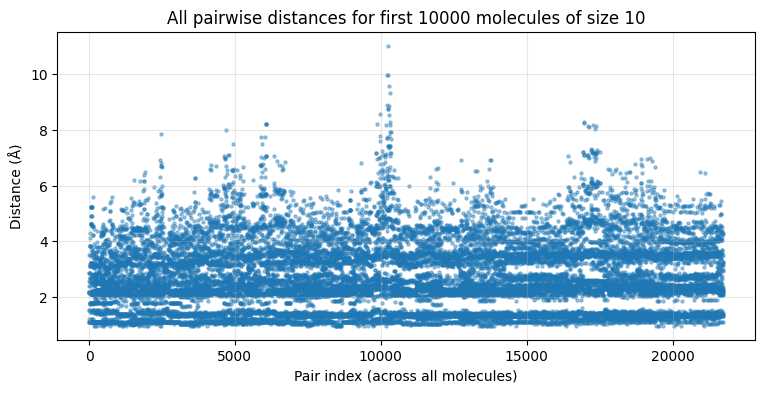

In [26]:
def plot_pairwise_distances_many(dataset, n_atoms=7, max_mols=50):
    subset = [d for d in dataset if d.num_nodes == n_atoms][:max_mols]

    all_dists = []
    for data in subset:
        N = data.num_nodes
        diff = data.pos.unsqueeze(0) - data.pos.unsqueeze(1)
        dist_matrix = diff.norm(dim=-1)
        i, j = torch.triu_indices(N, N, offset=1)
        dists = dist_matrix[i, j]
        all_dists.append(dists)

    all_dists = torch.cat(all_dists)

    indices = range(len(all_dists))

    plt.figure(figsize=(9,4))
    plt.scatter(indices, all_dists.cpu(), s=5, alpha=0.4)
    plt.xlabel("Pair index (across all molecules)")
    plt.ylabel("Distance (Å)")
    plt.title(f"All pairwise distances for first {max_mols} molecules of size {n_atoms}")
    plt.grid(alpha=0.3)
    plt.show()

# Example:
plot_pairwise_distances_many(dataset, n_atoms=10, max_mols=10000)
